## Exploratory Data Analysis Project


Data was sourced from openFDA - the US Food and Drug Administration (USFDA) API. We selected animal and veterinary API endpoints. The available API was the Adverse Event Report. We selected data on a small set of attributes of cats, recorded from 1987-2021. 

We obtained an API key, defined a base url, an made API calls. The output was converted to json format. The initial data retrieved had lots of missing data, so we decided to focus on specific breed. The key was not used for most of the data retrieval. We created a loop to obtain all 500 distinct records. Records were stored in a dataframe and also saved as a .csv file.

We identified the top three drugs reported to cause adverse reactions: Selamectin, Spinosad, and Fluralaner Spot-On Solution. We also explored associations between breed, gender, age, drug, and outcome. 


### Retrieving data and creating dataframe

In [1]:
#Setting dependencies

import numpy as np
import pandas as pd

import json
import requests
import time

import matplotlib.pyplot as plt
from pandas.plotting import table
from pprint import pprint
import seaborn as sns

# Import API key

from api_keys import api_key

In [2]:
# adding api_key to base url to obtain FDA information 
base_url = "https://api.fda.gov/drug/event.json?api_key=" + api_key

# changing the output to json 
req = requests.get(base_url)
data = req.json()

#print the data to show something is returned
#print(data)

In [3]:
#creating empty dictionary to store extracted data

cats_data = {'gender':[],
                'age':[],
                'weight':[],
                'breed':[],
                'drug':[],
                'outcome':[],
                'date_in':[]}

#verifying search on Cat species and positioning on breed work correctly 

base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+animal.breed.breed_component='Domestic Shorthair'"
req = requests.get(base_url)
data = req.json()

#add 1 row to the cats_data dictionary with information extracted - limit for this api call is 1 result

cats_data['gender'].append(data['results'][0]['animal']['gender'])
cats_data['age'].append(data['results'][0]['animal']['age']['min'])
cats_data['weight'].append(data['results'][0]['animal']['weight']['min'])
cats_data['breed'].append(data['results'][0]['animal']['breed']['breed_component'])
cats_data['drug'].append(data['results'][0]['drug'][0]['active_ingredients'][0]['name'])
cats_data['outcome'].append(data['results'][0]['outcome'][0]['medical_status'])
cats_data['date_in'].append(data['results'][0]['original_receive_date'])

print(cats_data)

{'gender': ['Male'], 'age': ['10.00'], 'weight': ['6.350'], 'breed': ['Domestic Shorthair'], 'drug': ['Spinosad'], 'outcome': ['Recovered/Normal'], 'date_in': ['20170508']}


In [4]:
# This url returns only the first match, so we used a loop to skip entries and pick up another one.otherwise the 
# same one is returned every time.
# Returning 500 results runs for a bit of time

cats_data = {'gender':[],
                'age':[],
                'weight':[],
                'breed':[],
                'drug':[],
                'outcome':[],
                'date_in':[]}
base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+(animal.breed.breed_component='Domestic Shorthair'+OR+animal.breed.breed_component='Domestic Longhair')"

# NB: It turns out that the API key was unnecessary - the + api_key part of the call was not copied, and the call was successful. These data were extracted without using the key.

counter = 1
for i in range(500):
    req = requests.get(base_url)
    data = req.json()

    #validate the data, if age and weight don't exist, replace with 0. If outcome, gender, breed, and drug
    #don't exist, replace with 'Unknown'. If original_receive_date doesn't exist, replace with nan.
    try:
        cats_data['age'].append(data['results'][0]['animal']['age']['min'])
    except:
        cats_data['age'].append('0')
    
    try:
        cats_data['weight'].append(data['results'][0]['animal']['weight']['min'])
    except:
        cats_data['weight'].append('0')

    try:
        cats_data['outcome'].append(data['results'][0]['outcome'][0]['medical_status'])
    except:
        cats_data['outcome'].append('Unknown')
    
    try:
        cats_data['date_in'].append(data['results'][0]['original_receive_date'])
    except:
        cats_data['date_in'].append(np.nan)

    try:
        cats_data['gender'].append(data['results'][0]['animal']['gender'])
    except:
        cats_data['gender'].append('Unknown')
    
    try:
        cats_data['breed'].append(data['results'][0]['animal']['breed']['breed_component'])
    except:
        cats_data['breed'].append('Unknown')
    
    try:
        cats_data['drug'].append(data['results'][0]['drug'][0]['active_ingredients'][0]['name'])
    except:
        cats_data['drug'].append('Unknown')
          
    counter +=1
    #counter is converted to a string and used as a skip value for gathering random records
    str_count = str(counter)
    base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+(animal.breed.breed_component='Domestic Shorthair'+OR+animal.breed.breed_component='Domestic Longhair')&skip=" + str_count
    

In [5]:
# converting the raw data in the cats dictionary to a dataframe and writing it out to a csv file

cat_df = pd.DataFrame.from_dict(cats_data)
cat_df.to_csv("cat_data.csv")

#print the info of the dataframe

cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gender   500 non-null    object
 1   age      500 non-null    object
 2   weight   500 non-null    object
 3   breed    500 non-null    object
 4   drug     500 non-null    object
 5   outcome  500 non-null    object
 6   date_in  500 non-null    object
dtypes: object(7)
memory usage: 27.5+ KB


#### Modifying datatypes for analysis

In [6]:
#converting the age and weight columns to numerics (floats)

cat_df[["age", "weight"]] = cat_df[["age", "weight"]].apply(pd.to_numeric)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gender   500 non-null    object 
 1   age      500 non-null    float64
 2   weight   500 non-null    float64
 3   breed    500 non-null    object 
 4   drug     500 non-null    object 
 5   outcome  500 non-null    object 
 6   date_in  500 non-null    object 
dtypes: float64(2), object(5)
memory usage: 27.5+ KB


In [7]:
# Extracting the year from the intake date

cat_df["date_in"] = pd.to_datetime(cat_df["date_in"])
cat_df["Year"] = cat_df['date_in'].dt.year

# Dropping intake date column

cat_df.drop('date_in', axis=1, inplace=True)
cat_df.head(15)

,gender,age,weight,breed,drug,outcome,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered/Normal,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered/Normal,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Outcome Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019
5,Male,2.0,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered/Normal,2019
7,Unknown,0.0,0.000,Cat (unknown),Imidacloprid,Recovered/Normal,2021
8,Male,9.0,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020
9,Female,11.0,2.722,Cat (unknown),Imidacloprid,Outcome Unknown,2021


In [8]:
# Renaming columns, including units when appropriate.

cat_df.columns = ['Gender', 'Age_y', 'Weight_kg', 'Breed', 'Drug', 'Status','Year']
cat_df.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered/Normal,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered/Normal,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Outcome Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019


### DATA FRAME WRANGLING

The goal is to minimize the influence of uninformative data in the dataframe. It's worth checking out the number of distinctive values for categorical variables. If there are too many, it can visualiztions can be cluttered. Categories with a low abundance of records will be dropped to minimize noise in the display.

First, we'll work with eliminating ambiguity by selecting the most informative categories and records from the data set.

In [9]:
cat_df['Status'].value_counts()

Unknown                   168
Outcome Unknown           102
Recovered/Normal          101
Ongoing                    80
Died                       40
Recovered with Sequela      5
Euthanized                  4
Name: Status, dtype: int64

There doesn't seem to be a distinction between "Outcome Unknown" and "Unknown", so these are combined. We shortened the string for one category to improve readability.

In [10]:
cat_df['Status'].replace('Outcome Unknown','Unknown', inplace=True)

cat_df['Status'].replace('Recovered/Normal','Recovered', inplace=True)
cat_df.head(10)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019
5,Male,2.0,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered,2019
7,Unknown,0.0,0.000,Cat (unknown),Imidacloprid,Recovered,2021
8,Male,9.0,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020
9,Female,11.0,2.722,Cat (unknown),Imidacloprid,Unknown,2021


Checking the numerical variables to see the abundance of uninformatitve zeroes. Ages and weights of zero are meaningless and can distory the statistical properties of the data set. This can distort displays and can pave the way for drawing inaccurate conclusions. 

In [11]:
cat_df['Age_y'].value_counts()

0.00     69
6.00     48
3.00     42
2.00     37
5.00     36
8.00     32
4.00     27
7.00     22
10.00    22
9.00     22
12.00    21
11.00    17
1.00     16
15.00    15
13.00    14
14.00     8
16.00     8
3.50      7
1.50      5
17.00     5
10.50     4
18.00     4
7.50      3
4.50      3
12.50     2
19.00     1
6.50      1
50.00     1
5.11      1
11.50     1
20.00     1
2.20      1
2.50      1
5.30      1
4.20      1
26.00     1
Name: Age_y, dtype: int64

In [12]:
cat_df['Weight_kg'].value_counts()

0.000    78
4.990    19
4.536    17
4.540    16
5.440    14
         ..
4.350     1
6.668     1
3.490     1
6.033     1
1.410     1
Name: Weight_kg, Length: 177, dtype: int64

We see that 78 of the records have a weight of 0 kgs, and 69 have an age of 0 years. We will filter the data and create a new frame without those recors. Thus, we'll restrict our attention to subjects estimated to be at least one year old, and one kg in weight.

In [51]:
# Inspecting breed category
cat_df['Breed'].value_counts();

There's a lot of ambiguity among the categories, and eleven categories had two or fewer records. Trimming the data set to eliminate the latter group. Then, re-code to combine "Cat (unknown)" with "Cat (other)" and "Mixed (Cat)".

In [14]:
cat_df['Breed'].replace('Cat (unknown)','Unknown', inplace=True)
cat_df['Breed'].replace('Cat (other)', 'Unknown', inplace=True)
cat_df['Breed'].replace('Mixed (Cat)', 'Unknown', inplace=True)
cat_df['Breed'].value_counts();

The next goal: create a dataframe that includes only the categories for which the frequency exceeds 25. Several filtering methods fail and yield the same TypeError. The naive work-around is to extract smaller dataframes from this larger one and then concatenate them. Let's see if this works: 

In [15]:
dshort = cat_df[cat_df['Breed'] == 'Domestic Shorthair']
dshort.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019


In [16]:
dlong = cat_df[cat_df['Breed'] == 'Domestic Longhair']
dlong.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered,2019
11,Male,8.0,4.540,Domestic Longhair,Spinosad,Recovered,2012
14,Male,7.0,5.400,Domestic Longhair,Pradofloxacin,Recovered,2013
35,Male,15.0,5.897,Domestic Longhair,Spinosad,Recovered,2015
69,Female,10.0,3.900,Domestic Longhair,Spinosad,Recovered with Sequela,2012


In [17]:
dmed = cat_df[cat_df['Breed'] == 'Domestic Mediumhair']
dmed.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
38,Female,3.0,6.396,Domestic Mediumhair,Spinosad,Recovered,2016
44,Male,6.0,7.484,Domestic Mediumhair,Fluralaner Spot-On Solution,Ongoing,2018
45,Female,0.0,0.000,Domestic Mediumhair,Selamectin,Ongoing,2018
49,Female,7.0,4.445,Domestic Mediumhair,Buprenorphine,Ongoing,2020
53,Male,6.0,5.440,Domestic Mediumhair,Spinosad,Recovered,2013


In [18]:
dunsp = cat_df[cat_df['Breed'] == 'Domestic (unspecified)']
dunsp.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
16,Male,2.0,6.35,Domestic (unspecified),Pyrantel Pamoate,Unknown,2007
17,Male,10.0,5.50,Domestic (unspecified),Enrofloxacin,Unknown,2006
20,Male,15.0,8.16,Domestic (unspecified),Cyclosporine,Unknown,2011
21,Female,17.0,3.18,Domestic (unspecified),Ketamine Hydrochloride,Unknown,2004
22,Male,2.0,4.99,Domestic (unspecified),Lufenuron,Unknown,1996


In [19]:
unkn = cat_df[cat_df['Breed'] == 'Unknown']
unkn.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
7,Unknown,0.0,0.000,Unknown,Imidacloprid,Recovered,2021
9,Female,11.0,2.722,Unknown,Imidacloprid,Unknown,2021
10,Unknown,0.0,0.000,Unknown,Praziquantel,Unknown,2021
12,Unknown,0.0,3.180,Unknown,Griseofulvin,Unknown,1996
18,Unknown,3.0,3.180,Unknown,Ketamine Hydrochloride,Unknown,1988


In [20]:
frames = [dshort, dlong, dmed, dunsp, unkn]

In [21]:
cat = pd.concat(frames)
#cat

Now we can drop the records with the uninformative zeroes from the dataframe. First, check the stats on the numerical variables before dropping

In [22]:
cat['Age_y'].describe()

count    488.000000
mean       6.336701
std        5.202351
min        0.000000
25%        2.000000
50%        6.000000
75%       10.000000
max       50.000000
Name: Age_y, dtype: float64

In [23]:
cat['Weight_kg'].describe()

count    488.000000
mean       3.928557
std        2.383235
min        0.000000
25%        2.686250
50%        4.263500
75%        5.440000
max       11.790000
Name: Weight_kg, dtype: float64

In [24]:
cat.drop(cat.index[cat['Age_y'] == 0], inplace = True)
cat['Age_y'].describe()

count    420.000000
mean       7.362643
std        4.887239
min        1.000000
25%        3.500000
50%        6.000000
75%       10.000000
max       50.000000
Name: Age_y, dtype: float64

In [25]:
cat.drop(cat.index[cat['Weight_kg'] == 0], inplace = True)
cat['Weight_kg'].describe()

count    398.000000
mean       4.658246
std        1.850667
min        0.360000
25%        3.370000
50%        4.540000
75%        5.897000
max       11.790000
Name: Weight_kg, dtype: float64

We see that the means and standard deviations have changed.

At this point, we now have informative records for about 400 cats. Now, we can restrict the numbers of drugs to include in the plots. First, we check the frequency of drugs, and then filter out all of the records for which the abundance of a drug is >= 10

In [27]:
cat['Drug'].value_counts()

Selamectin                     73
Spinosad                       59
Fluralaner Spot-On Solution    27
Nitenpyram                     21
Imidacloprid                   18
                               ..
Mirtazapine                     1
Methylprednisolone Acetate      1
Alfaxalone                      1
Ear Cleansers/Astringents       1
Ferric Cation                   1
Name: Drug, Length: 66, dtype: int64

In [28]:
catdf = cat.groupby('Drug').filter(lambda x: (x['Drug'].count()>=10).any())

In [29]:
catdf;

In [30]:
catdf['Drug'].value_counts()

Selamectin                     73
Spinosad                       59
Fluralaner Spot-On Solution    27
Nitenpyram                     21
Imidacloprid                   18
Meloxicam                      15
Praziquantel                   15
Lufenuron                      12
Name: Drug, dtype: int64

The dataframe now has 240 records and is focused on 8 drugs. The smallest category for the 'Drug' variable, Lufenuron (n=12), represents 5% of the data. That's probably too small for any category, but that will be the lower limit for this exercise.

Finally, we look at the "Gender" category:

In [31]:
catdf['Gender'].value_counts()

Male       137
Female      98
Unknown      4
Mixed        1
Name: Gender, dtype: int64

There are four categories, but we didn't drop "Unknown" and "Mixed" from the set. "Unknown" comes from lack of information, and "Mixed" may or may not be a hermaphrodite. 

Now, we can run the summary statistics on the numerical values:

In [32]:
catdf['Age_y'].describe()

count    240.000000
mean       6.963792
std        4.882630
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       50.000000
Name: Age_y, dtype: float64

That max cat age could be a problem. There are two instances of cats over the age of 25, those will be dropped. 

In [35]:
catdf.drop(catdf.index[catdf['Age_y'] >= 26], inplace = True)
catdf['Age_y'].describe()

count    239.000000
mean       6.783724
std        4.015680
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       19.000000
Name: Age_y, dtype: float64

In [36]:
catdf['Weight_kg'].describe()

count    239.000000
mean       4.812004
std        1.863792
min        0.360000
25%        3.629000
50%        4.580000
75%        5.900000
max       11.790000
Name: Weight_kg, dtype: float64

And summary proportions of nominal categorical variables:

In [37]:
catdf['Breed'].value_counts()/catdf['Breed'].value_counts().sum()

Domestic Shorthair        0.510460
Domestic (unspecified)    0.271967
Domestic Longhair         0.083682
Unknown                   0.071130
Domestic Mediumhair       0.062762
Name: Breed, dtype: float64

In [38]:
catdf['Gender'].value_counts()/catdf['Gender'].value_counts().sum()

Male       0.569038
Female     0.410042
Unknown    0.016736
Mixed      0.004184
Name: Gender, dtype: float64

In [39]:
catdf['Status'].value_counts()/catdf['Status'].value_counts().sum()

Unknown                   0.460251
Recovered                 0.301255
Ongoing                   0.163180
Died                      0.054393
Recovered with Sequela    0.012552
Euthanized                0.008368
Name: Status, dtype: float64

In [40]:
catdf['Drug'].value_counts()/catdf['Drug'].value_counts().sum()

Selamectin                     0.301255
Spinosad                       0.246862
Fluralaner Spot-On Solution    0.112971
Nitenpyram                     0.087866
Imidacloprid                   0.075314
Meloxicam                      0.062762
Praziquantel                   0.062762
Lufenuron                      0.050209
Name: Drug, dtype: float64

#### Categorical variables: visualizing proportions

With the exception of age, the variables in this dataframe are nominal categorical ones. It's helpful to visualize each variable using a simple display. This sets the foundation for understanding more complicated displays. Since these variables are nominal, the best choice is a pie chart. We do this below:

<AxesSubplot:ylabel='None'>

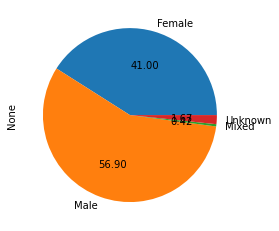

In [41]:
catdf.groupby('Gender').size().plot(kind='pie', autopct='%.2f')

<AxesSubplot:ylabel='None'>

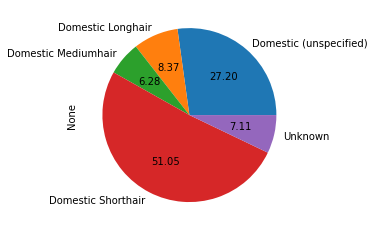

In [42]:
catdf.groupby('Breed').size().plot(kind='pie', autopct='%.2f')

<AxesSubplot:ylabel='None'>

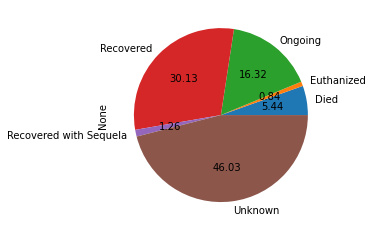

In [43]:
catdf.groupby('Status').size().plot(kind='pie', autopct='%.2f')

<AxesSubplot:ylabel='None'>

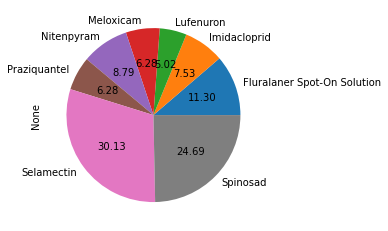

In [44]:
catdf.groupby('Drug').size().plot(kind='pie', autopct='%.2f')

In summary, in this data set, the gender split is nearly 60/40 male/female. There's not a whole lot of variety regarding breed. Domestic Shorthairs comprise at minimum half of the sample. The Domestic Medium and Longhair categories account for less than 15% of the data. The balance is largely unspecified, and quite possibly Domestic Shorthair. Regarding outcomes, forty-six percent were unknown, thirty percent had recovered, and about 5% had died. Finally, of the drugs reported, the three most abundant were Selamectin (30%), Spinosad (almost 25%) and Fluralaner Spot-On Solution (11%). 

### CREATING VISUALIZATIONS TO EXPLORE QUESTIONS

These data comprise reports of incidents where drug exposure resulted in adverse reactions in cats. We considered several questions:

### 1) What is the distribution of drug type among breeds? 

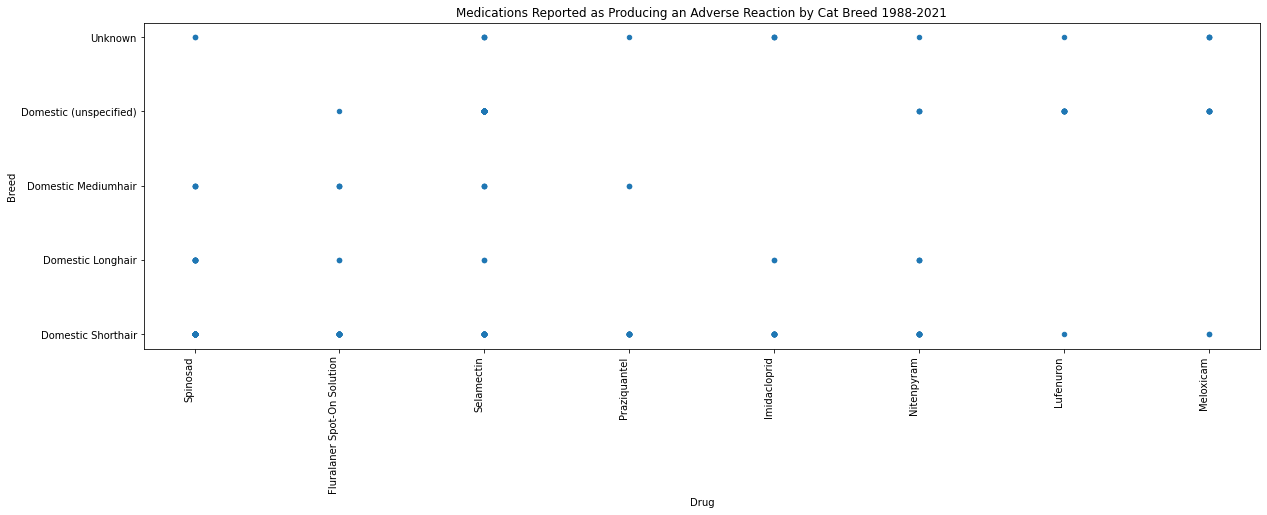

In [45]:
#create scatter plot

catdf.plot( y='Breed', x='Drug', kind='scatter', figsize=(20,6))

#create labels 
#plt.xlabel('x')
#plt.ylabel('y')
 
# display the title

plt.title("Medications Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")

#Rotate axis text
plt.xticks(rotation=90, ha='right')
#save image
plt.savefig("Medications Reported as Producing an Adverse Reaction by Cat Breed 1988-2021.png") 
#show plot
plt.show()

### 2) What is the relationship between age and death?

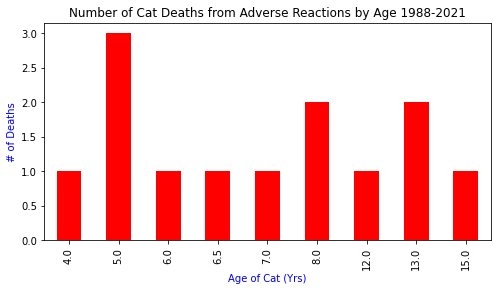

In [46]:
#sort data by deaths 

g=catdf[catdf["Status"] == 'Died']

#count deaths by age and sort order
h=g["Age_y"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="age", figsize=(8,4), color="red")
#create labels 
plt.xlabel('Age of Cat (Yrs)',color="blue")
plt.ylabel('# of Deaths',color="blue" )
 
# display the title
plt.title("Number of Cat Deaths from Adverse Reactions by Age 1988-2021")
#plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Number of Cat Deaths by Age 1988-2021.png") 
#show plot
plt.show()

### 3) Facet plot: relationships among breed, gender, drug, age, and outcome

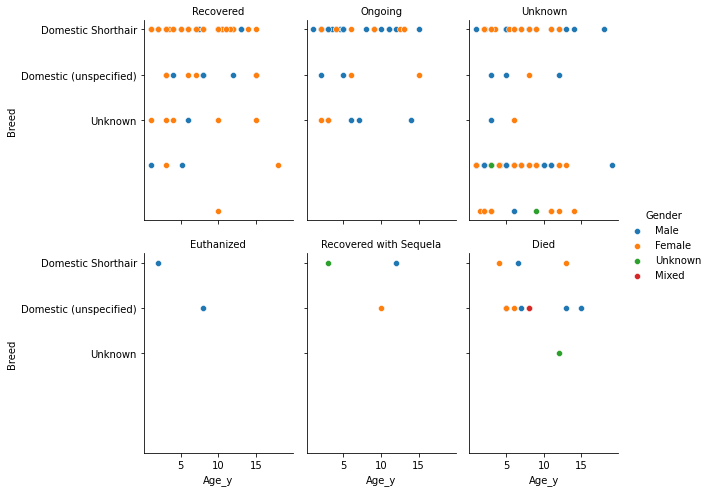

In [47]:
l = sns.FacetGrid(catdf, col="Status", hue="Gender", col_wrap=3)

l.map(sns.scatterplot, "Age_y", "Breed")

l.add_legend()
plt.subplots_adjust(top=1.1)
l.set_titles("{col_name}")

#l.fig.suptitle('Reported Cat Medication Reaction Outcomes by Breed and Age 1989-2021')
#save image'Reported Cat Medication Reaction Outcomes by Breed and Age 1989-2021'
plt.savefig("Reported Cat Medication Reaction Outcomes by Breed and Age 1989-2021.png") 
plt.show()

### 4) What is the relationship between age and the outcome of having recovered?

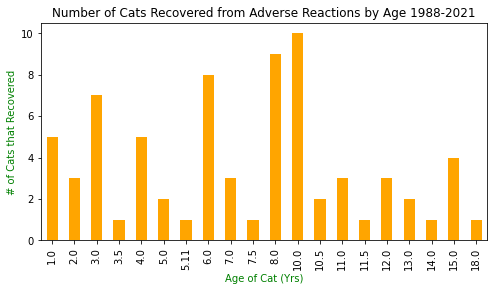

In [48]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Recovered']
#count deaths by age and sort order
h=g["Age_y"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="age", figsize=(8,4), color="orange")
#create labels 
plt.xlabel('Age of Cat (Yrs)',color="green")
plt.ylabel('# of Cats that Recovered',color="green" )
 
# display the title
plt.title("Number of Cats Recovered from Adverse Reactions by Age 1988-2021")
#plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Number of Cats Recovered from Adverse Reactions by Age 1988-2021.png") 
#show plot
plt.show()

In [ ]:
## not sure how this one is different from the first one

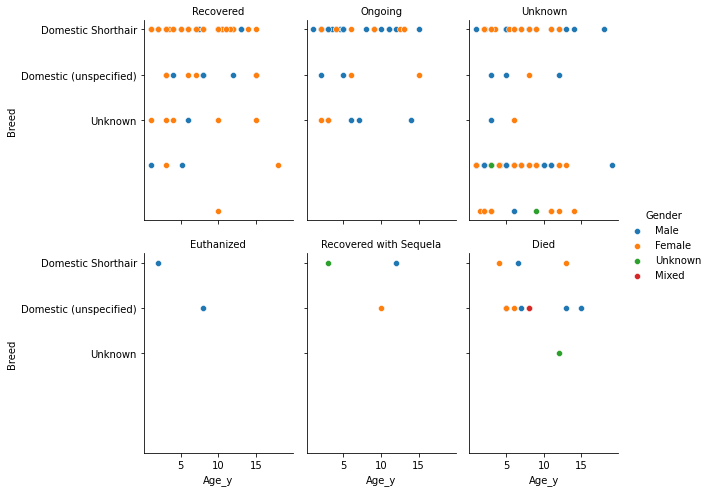

In [52]:
l = sns.FacetGrid(catdf, col="Status", hue="Gender", col_wrap=3)

l.map(sns.scatterplot, "Age_y", "Breed")

l.add_legend()
plt.subplots_adjust(top=1.1)
l.set_titles("{col_name}")

#l.fig.suptitle('Reported Cat Medication Reaction Outcomes by Breed and Age 1989-2021')

plt.show()

### 5) How was reaction to selamectin distributed across breed categories?

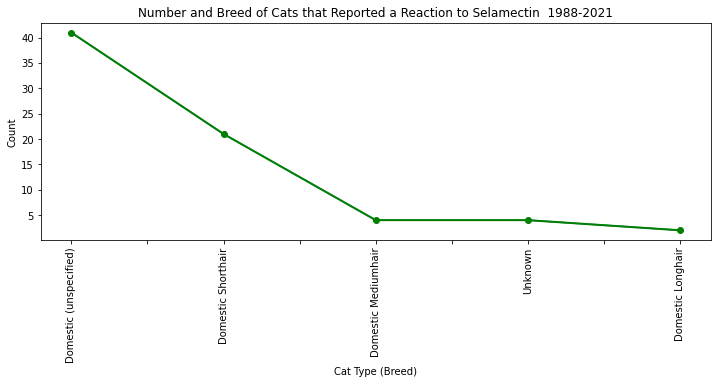

In [53]:
#sort data by deaths 
d=catdf[catdf["Drug"] == 'Selamectin']
q=catdf[catdf["Breed"] == 'Domestic Shorthair']
#count deaths by age and sort order
m=d["Breed"].value_counts()
#h
#create bar graph
m.plot(x="Breed", figsize=(12,4))
#create labels 
plt.xlabel('Cat Type (Breed)')
plt.ylabel('Count' )
#plots df "go-" creates a green line with circles
plt.plot(m, 'go-', linewidth=2)
#tick marks
plt.tick_params('y') 
# display the title
plt.title("Number and Breed of Cats that Reported a Reaction to Selamectin  1988-2021")
plt.xticks(rotation=90)
plt.savefig("Number and Breed of Cats that Reported a Reaction to Selamectin  1988-2021.png") 
#show plot
#plt.show()